# Load Data

In [8]:
# 只选择四类话题的新闻数据，涉及计算机科学、棒球、医学和宗教

import helper

categories = ['comp.graphics','rec.sport.baseball','sci.med', 'soc.religion.christian']

newsgroups_train, newsgroups_test, newsgroups_data = helper.load_data(categories)

In [9]:
print(len(newsgroups_train.data))
print(len(newsgroups_test.data))
print(len(newsgroups_data.data))

2374
1580
3954


# Word2Vec

In [10]:
from gensim.models import word2vec
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [5]:
# 采用Mikolov曾经使用过的text8数据包进行训练

text8_sentences = word2vec.Text8Corpus('text8')

model = word2vec.Word2Vec(text8_sentences, size=100, window=5, min_count=3, workers=4)

2017-11-08 15:09:39,200 : INFO : collecting all words and their counts
2017-11-08 15:09:39,203 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-11-08 15:09:44,443 : INFO : collected 253854 word types from a corpus of 17005207 raw words and 1701 sentences
2017-11-08 15:09:44,444 : INFO : Loading a fresh vocabulary
2017-11-08 15:09:44,756 : INFO : min_count=3 retains 100038 unique words (39% of original 253854, drops 153816)
2017-11-08 15:09:44,757 : INFO : min_count=3 leaves 16816094 word corpus (98% of original 17005207, drops 189113)
2017-11-08 15:09:45,033 : INFO : deleting the raw counts dictionary of 253854 items
2017-11-08 15:09:45,044 : INFO : sample=0.001 downsamples 38 most-common words
2017-11-08 15:09:45,045 : INFO : downsampling leaves estimated 12612693 word corpus (75.0% of prior 16816094)
2017-11-08 15:09:45,046 : INFO : estimated required memory for 100038 words and 100 dimensions: 130049400 bytes
2017-11-08 15:09:45,379 : INFO : resetting 

In [61]:
model.most_similar(['man'])

[('woman', 0.7156496047973633),
 ('girl', 0.6739988327026367),
 ('creature', 0.6172822117805481),
 ('person', 0.5797319412231445),
 ('god', 0.5764418244361877),
 ('soul', 0.5685361623764038),
 ('evil', 0.5667415857315063),
 ('demon', 0.5553998947143555),
 ('humanity', 0.5522022247314453),
 ('curse', 0.5471194982528687)]

In [7]:
model.most_similar(positive=['woman','king'], negative=['man'], topn=3)

[('queen', 0.7154322266578674),
 ('empress', 0.6414068937301636),
 ('princess', 0.6256770491600037)]

In [67]:
# 测试保存和加载词向量模型

model.wv.save_word2vec_format('models/deep_learning/text.model.bin', binary=True)

2017-11-09 15:59:25,552 : INFO : storing 100038x100 projection weights into models/deep_learning/text.model.bin


In [11]:
import gensim

text8_model = gensim.models.KeyedVectors.load_word2vec_format('models/deep_learning/text.model.bin', binary=True)

2017-12-08 03:26:07,816 : INFO : loading projection weights from models/deep_learning/text.model.bin
2017-12-08 03:26:08,717 : INFO : loaded (100038, 100) matrix from models/deep_learning/text.model.bin


In [6]:
text8_model.most_similar(['man'])

2017-11-16 10:58:15,125 : INFO : precomputing L2-norms of word weight vectors


[('woman', 0.7156496047973633),
 ('girl', 0.6739988327026367),
 ('creature', 0.6172822117805481),
 ('person', 0.5797319412231445),
 ('god', 0.5764418244361877),
 ('soul', 0.5685361623764038),
 ('evil', 0.5667415857315063),
 ('demon', 0.5553998947143555),
 ('humanity', 0.5522022247314453),
 ('curse', 0.5471194982528687)]

# 向量化数据

In [12]:
from keras.preprocessing.text import Tokenizer

MAX_SEQUENCE_LENGTH = 800  # 每条新闻最大长度
EMBEDDING_DIM = 100         # 词向量空间维度

tokenizer = Tokenizer(num_words=None,
                          filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                          lower=True,
                          split=" ",
                          char_level=False)
# fit on all texts
tokenizer.fit_on_texts(newsgroups_data.data)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 38983 unique tokens.


In [13]:
X_train, y_train, X_test, y_test = helper.vectorize_data(tokenizer, \
                                                         newsgroups_data, newsgroups_train, newsgroups_test)

Shape of train data tensor: (2374, 800)
Shape of train label tensor: (2374, 4)
Shape of test data tensor: (1580, 800)
Shape of test label tensor: (1580, 4)


# CNN+Word2Vec

In [14]:
import numpy as np
from keras.layers import Embedding

embedding_layer = helper.generate_embedding_layer(word_index, text8_model)

In [43]:
from keras.callbacks import ModelCheckpoint

cnn_model = helper.get_cnn_model(embedding_layer, y_train)

# checkpoint
filepath="weights-improvement-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Fit the model
cnn_model.fit(X_train, y_train, validation_split = 0.2, epochs=50, \
              batch_size=128, callbacks=callbacks_list, verbose=0)

Epoch 00001: val_acc improved from -inf to 0.30737, saving model to weights-improvement-01-0.3074.hdf5
Epoch 00002: val_acc improved from 0.30737 to 0.46316, saving model to weights-improvement-02-0.4632.hdf5
Epoch 00003: val_acc improved from 0.46316 to 0.51368, saving model to weights-improvement-03-0.5137.hdf5
Epoch 00004: val_acc improved from 0.51368 to 0.65053, saving model to weights-improvement-04-0.6505.hdf5
Epoch 00005: val_acc improved from 0.65053 to 0.75158, saving model to weights-improvement-05-0.7516.hdf5
Epoch 00006: val_acc improved from 0.75158 to 0.77684, saving model to weights-improvement-06-0.7768.hdf5
Epoch 00007: val_acc improved from 0.77684 to 0.85053, saving model to weights-improvement-07-0.8505.hdf5
Epoch 00008: val_acc did not improve
Epoch 00009: val_acc did not improve
Epoch 00010: val_acc improved from 0.85053 to 0.88421, saving model to weights-improvement-10-0.8842.hdf5
Epoch 00011: val_acc did not improve
Epoch 00012: val_acc improved from 0.88421 t

In [44]:
# 通过 ModelCheckpoint 的结果，epochs=50可以训练出最好的模型
cnn_model = helper.get_cnn_model(embedding_layer, y_train)
cnn_model.fit(X_train, y_train, epochs=50, batch_size=128)

Epoch 1/50
2374/2374 [==============================] - 12s 5ms/step - loss: 1.8683 - acc: 0.3239
Epoch 2/50
2374/2374 [==============================] - 12s 5ms/step - loss: 1.3325 - acc: 0.3825
Epoch 3/50
2374/2374 [==============================] - 12s 5ms/step - loss: 1.2504 - acc: 0.4322
Epoch 4/50
2374/2374 [==============================] - 12s 5ms/step - loss: 1.1072 - acc: 0.5215
Epoch 5/50
2374/2374 [==============================] - 12s 5ms/step - loss: 0.8770 - acc: 0.6563
Epoch 6/50
2374/2374 [==============================] - 12s 5ms/step - loss: 0.7519 - acc: 0.7115
Epoch 7/50
2374/2374 [==============================] - 13s 5ms/step - loss: 0.6160 - acc: 0.7616
Epoch 8/50
2374/2374 [==============================] - 12s 5ms/step - loss: 0.5421 - acc: 0.7944
Epoch 9/50
2374/2374 [==============================] - 11s 5ms/step - loss: 0.5166 - acc: 0.8130
Epoch 10/50
2374/2374 [==============================] - 12s 5ms/step - loss: 0.4550 - acc: 0.8260
Epoch 11/50
2374/23

In [45]:
print(cnn_model.evaluate(X_test,y_test))

1580/1580 [==============================] - 3s 2ms/step
[0.40519786827926396, 0.88164556946935535]


In [50]:
# serialize model to JSON
model_json = cnn_model.to_json()
with open("models/deep_learning/cnn_model/cnn_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
cnn_model.save_weights("models/deep_learning/cnn_model/cnn_model.h5")
print("Saved model to disk")

Saved model to disk


In [53]:
# 测试保存的模型是否能够被重载并再次使用

from keras.models import model_from_json

# load json and create model
json_file = open('models/deep_learning/cnn_model/cnn_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("models/deep_learning/cnn_model/cnn_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [55]:
loaded_model.compile(loss='categorical_crossentropy',
                     optimizer='rmsprop',
                     metrics=['acc'])
print(loaded_model.evaluate(X_test,y_test))

1580/1580 [==============================] - 3s 2ms/step
[0.40519786827926396, 0.88164556946935535]


# LSTM(RNN) + Word2Vec

In [12]:
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import LSTM, Embedding
from keras.models import Sequential

def get_rnn_model():
    rnn_model = Sequential()
    rnn_model.add(embedding_layer)
    rnn_model.add(Dropout(0.2))

    rnn_model.add(LSTM(128, activation='tanh', recurrent_activation='hard_sigmoid', 
                       dropout=0.2, recurrent_dropout=0.2))
    
    # rnn_model.add(LSTM(128, activation='tanh', recurrent_activation='hard_sigmoid', 
    #                    dropout=0.3, recurrent_dropout=0.3))
    # rnn_model.add(Dropout(0.5))
    
    # rnn_model.add(LSTM(256,  activation='tanh', recurrent_activation='hard_sigmoid', 
    #                    dropout=0.2, recurrent_dropout=0.2))
    
    rnn_model.add(Dropout(0.2))
    
    rnn_model.add(Dense(y_train.shape[1], activation='softmax'))

    rnn_model.compile(loss='categorical_crossentropy',
                      optimizer='rmsprop',
                      metrics=['acc'])
    
    return rnn_model

### 测试 LSTM cell 为128个的RNN模型

In [43]:
# 测试 LSTM cell较少的RNN模型，128个

from keras.callbacks import ModelCheckpoint

simple_rnn_model = get_rnn_model()

# checkpoint
filepath="weights-improvement-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Fit the model
simple_rnn_model.fit(X_train, y_train, validation_split = 0.2, epochs=50, \
                     batch_size=128, callbacks=callbacks_list, verbose=0)

Epoch 00000: val_acc improved from -inf to 0.62947, saving model to weights-improvement-00-0.6295.hdf5
Epoch 00001: val_acc improved from 0.62947 to 0.78737, saving model to weights-improvement-01-0.7874.hdf5
Epoch 00002: val_acc improved from 0.78737 to 0.81474, saving model to weights-improvement-02-0.8147.hdf5
Epoch 00003: val_acc improved from 0.81474 to 0.82526, saving model to weights-improvement-03-0.8253.hdf5
Epoch 00004: val_acc improved from 0.82526 to 0.84842, saving model to weights-improvement-04-0.8484.hdf5
Epoch 00005: val_acc improved from 0.84842 to 0.85474, saving model to weights-improvement-05-0.8547.hdf5
Epoch 00006: val_acc did not improve
Epoch 00007: val_acc improved from 0.85474 to 0.86737, saving model to weights-improvement-07-0.8674.hdf5
Epoch 00008: val_acc did not improve
Epoch 00009: val_acc improved from 0.86737 to 0.89895, saving model to weights-improvement-09-0.8989.hdf5
Epoch 00010: val_acc improved from 0.89895 to 0.90105, saving model to weights-im

In [13]:
# 通过 ModelCheckpoint 的结果，epochs=44可以训练出最好的模型
simple_rnn_model = get_rnn_model()
simple_rnn_model.fit(X_train, y_train, epochs=44, batch_size=128)

Epoch 1/44
2374/2374 [==============================] - 32s 14ms/step - loss: 1.1637 - acc: 0.4949
Epoch 2/44
2374/2374 [==============================] - 32s 14ms/step - loss: 0.8135 - acc: 0.6862
Epoch 3/44
2374/2374 [==============================] - 33s 14ms/step - loss: 0.6927 - acc: 0.7422
Epoch 4/44
2374/2374 [==============================] - 31s 13ms/step - loss: 0.6302 - acc: 0.7641
Epoch 5/44
2374/2374 [==============================] - 30s 13ms/step - loss: 0.5920 - acc: 0.7784
Epoch 6/44
2374/2374 [==============================] - 31s 13ms/step - loss: 0.5129 - acc: 0.8151
Epoch 7/44
2374/2374 [==============================] - 31s 13ms/step - loss: 0.5204 - acc: 0.8159
Epoch 8/44
2374/2374 [==============================] - 31s 13ms/step - loss: 0.4702 - acc: 0.8281
Epoch 9/44
2374/2374 [==============================] - 31s 13ms/step - loss: 0.4063 - acc: 0.8530
Epoch 10/44
2374/2374 [==============================] - 31s 13ms/step - loss: 0.4083 - acc: 0.8568
Epoch 11/

In [14]:
print(simple_rnn_model.evaluate(X_test,y_test))

1580/1580 [==============================] - 9s 6ms/step
[0.38230368514792828, 0.89430379746835442]


In [35]:
# serialize model to JSON
rnn_model_json = simple_rnn_model.to_json()
with open("models/deep_learning/rnn_model/rnn_model.json", "w") as json_file:
    json_file.write(rnn_model_json)
# serialize weights to HDF5
simple_rnn_model.save_weights("models/deep_learning/rnn_model/rnn_model.h5")
print("Saved model to disk")

Saved model to disk


### 测试LSTM cell为256个的模型

In [60]:
# RNN模型中有256个LSTM cell

from keras.callbacks import ModelCheckpoint

rnn_model = get_rnn_model()

# checkpoint
filepath="weights-improvement-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Fit the model
rnn_model.fit(X_train, y_train, validation_split = 0.2, epochs=50, \
              batch_size=128, callbacks=callbacks_list, verbose=0)

Epoch 00001: val_acc improved from -inf to 0.70526, saving model to weights-improvement-01-0.7053.hdf5
Epoch 00002: val_acc improved from 0.70526 to 0.77684, saving model to weights-improvement-02-0.7768.hdf5
Epoch 00003: val_acc did not improve
Epoch 00004: val_acc improved from 0.77684 to 0.84842, saving model to weights-improvement-04-0.8484.hdf5
Epoch 00005: val_acc did not improve
Epoch 00006: val_acc did not improve
Epoch 00007: val_acc improved from 0.84842 to 0.86105, saving model to weights-improvement-07-0.8611.hdf5
Epoch 00008: val_acc improved from 0.86105 to 0.87789, saving model to weights-improvement-08-0.8779.hdf5
Epoch 00009: val_acc did not improve
Epoch 00010: val_acc did not improve
Epoch 00011: val_acc did not improve
Epoch 00012: val_acc improved from 0.87789 to 0.89895, saving model to weights-improvement-12-0.8989.hdf5
Epoch 00013: val_acc did not improve
Epoch 00014: val_acc did not improve
Epoch 00015: val_acc did not improve
Epoch 00016: val_acc did not impro

In [ ]:
# 通过 ModelCheckpoint 的结果，epochs=48可以训练出最好的模型
rnn_model = get_rnn_model()
rnn_model.fit(X_train, y_train, epochs=48, batch_size=128)

Epoch 1/48
2374/2374 [==============================] - 77s 33ms/step - loss: 1.1539 - acc: 0.5088
Epoch 2/48
2374/2374 [==============================] - 74s 31ms/step - loss: 0.8357 - acc: 0.6723
Epoch 3/48
2374/2374 [==============================] - 77s 32ms/step - loss: 0.6541 - acc: 0.7616
Epoch 4/48
2374/2374 [==============================] - 75s 32ms/step - loss: 0.6112 - acc: 0.7818
Epoch 5/48
2374/2374 [==============================] - 77s 32ms/step - loss: 0.5399 - acc: 0.8147
Epoch 6/48
2374/2374 [==============================] - 74s 31ms/step - loss: 0.5010 - acc: 0.8260
Epoch 7/48
2374/2374 [==============================] - 74s 31ms/step - loss: 0.4963 - acc: 0.8298
Epoch 8/48
2374/2374 [==============================] - 73s 31ms/step - loss: 0.4294 - acc: 0.8551
Epoch 9/48
2374/2374 [==============================] - 73s 31ms/step - loss: 0.4183 - acc: 0.8631
Epoch 10/48
2374/2374 [==============================] - 73s 31ms/step - loss: 0.4056 - acc: 0.8703
Epoch 11/

In [23]:
print(rnn_model.evaluate(X_test,y_test))

1580/1580 [==============================] - 25s 16ms/step
[0.35807295835848096, 0.88291139240506333]


### 继续探索LSTM cell为128个的模型

In [24]:
from keras.callbacks import ModelCheckpoint

simple_rnn_model_2 = get_rnn_model()

# checkpoint
filepath="weights-improvement-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Fit the model
simple_rnn_model_2.fit(X_train, y_train, validation_split = 0.2, epochs=50, \
                       batch_size=128, callbacks=callbacks_list, verbose=0)

Epoch 00001: val_acc improved from -inf to 0.58737, saving model to weights-improvement-01-0.5874.hdf5
Epoch 00002: val_acc improved from 0.58737 to 0.67368, saving model to weights-improvement-02-0.6737.hdf5
Epoch 00003: val_acc improved from 0.67368 to 0.74105, saving model to weights-improvement-03-0.7411.hdf5
Epoch 00004: val_acc improved from 0.74105 to 0.77895, saving model to weights-improvement-04-0.7789.hdf5
Epoch 00005: val_acc improved from 0.77895 to 0.77895, saving model to weights-improvement-05-0.7789.hdf5
Epoch 00006: val_acc improved from 0.77895 to 0.81684, saving model to weights-improvement-06-0.8168.hdf5
Epoch 00007: val_acc improved from 0.81684 to 0.84842, saving model to weights-improvement-07-0.8484.hdf5
Epoch 00008: val_acc did not improve
Epoch 00009: val_acc improved from 0.84842 to 0.85053, saving model to weights-improvement-09-0.8505.hdf5
Epoch 00010: val_acc did not improve
Epoch 00011: val_acc did not improve
Epoch 00012: val_acc improved from 0.85053 t

In [ ]:
# 通过 ModelCheckpoint 的结果，epochs=40可以训练出最好的模型
simple_rnn_model_2 = get_rnn_model()
simple_rnn_model_2.fit(X_train, y_train, epochs=40, batch_size=128)

In [27]:
print(simple_rnn_model_2.evaluate(X_test,y_test))

1580/1580 [==============================] - 9s 6ms/step
[0.35345583239782458, 0.89113924050632909]


### 记录卷积神经网络的学习曲线，寻找更好的epoch

In [15]:
cnn_model = helper.get_cnn_model(embedding_layer, y_train)

history = cnn_model.fit(X_train, y_train, validation_split = 0.2, epochs=50, \
                        batch_size=128, verbose=0)

In [16]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


In [58]:
history.history['val_acc'][10:18]

[0.89684210689444288,
 0.888421054262864,
 0.90315789586619322,
 0.88210526504014664,
 0.89473684373654816,
 0.89473684361106476,
 0.90315789599167673,
 0.90315789636812716]

In [59]:
history.history['val_loss'][10:18]

[0.29485621998184608,
 0.35605605865779677,
 0.31848961390947039,
 0.37608345132125054,
 0.33130517005920412,
 0.37729367469486436,
 0.29123197197914125,
 0.29378827804013302]

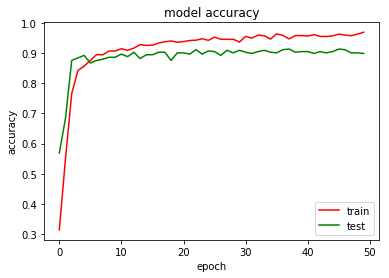

In [25]:
import visualizer

visualizer.plot_accuracy(history)

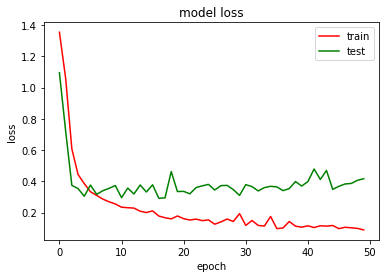

In [29]:
# summarize history for loss
visualizer.plot_loss(history)

In [60]:
# 综合分析val_acc和val_test，epochs=17可以训练出最好的模型
cnn_model = helper.get_cnn_model(embedding_layer, y_train)
cnn_model.fit(X_train, y_train, epochs=17, batch_size=128)

Epoch 1/17
2374/2374 [==============================] - 11s - loss: 1.3405 - acc: 0.3534    
Epoch 2/17
2374/2374 [==============================] - 11s - loss: 1.0069 - acc: 0.5670    
Epoch 3/17
2374/2374 [==============================] - 11s - loss: 0.5835 - acc: 0.8020    
Epoch 4/17
2374/2374 [==============================] - 11s - loss: 0.3965 - acc: 0.8551    
Epoch 5/17
2374/2374 [==============================] - 11s - loss: 0.3536 - acc: 0.8677    
Epoch 6/17
2374/2374 [==============================] - 11s - loss: 0.3374 - acc: 0.8762    
Epoch 7/17
2374/2374 [==============================] - 11s - loss: 0.2854 - acc: 0.8993    
Epoch 8/17
2374/2374 [==============================] - 11s - loss: 0.2795 - acc: 0.8993    
Epoch 9/17
2374/2374 [==============================] - 11s - loss: 0.2528 - acc: 0.9019    
Epoch 10/17
2374/2374 [==============================] - 11s - loss: 0.2502 - acc: 0.9090    
Epoch 11/17
2374/2374 [==============================] - 11s - loss: 

In [61]:
print(cnn_model.evaluate(X_test,y_test))

1568/1580 [============================>.] - ETA: 0s[0.38855008426346355, 0.89240506344203707]


In [62]:
# serialize model to JSON
model_json = cnn_model.to_json()
with open("models/deep_learning/cnn_model/cnn_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
cnn_model.save_weights("models/deep_learning/cnn_model/cnn_model.h5")
print("Saved model to disk")

Saved model to disk


### 记录循环神经网络的学习曲线，寻找更好的epoch

In [34]:
rnn_model = get_rnn_model()

# Fit the model
rnn_history = rnn_model.fit(X_train, y_train, validation_split = 0.2, epochs=50, \
                            batch_size=128, verbose=0)

In [39]:
rnn_history.history['val_acc'][29:32]

[0.90526315940053836, 0.90736842255843309, 0.89263158070413695]

In [41]:
rnn_history.history['val_loss'][29:32]

[0.24832860871365195, 0.25200192746363187, 0.31205478919179819]

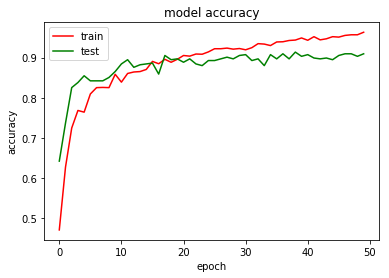

In [36]:
# summarize history for accuracy
visualizer.plot_accuracy(rnn_history)

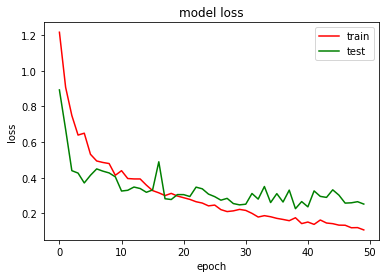

In [37]:
# summarize history for loss
visualizer.plot_loss(rn_history)

In [14]:
# 综合分析val_acc和val_test，epochs=30可以训练出最好的模型
rnn_model = get_rnn_model()
rnn_model.fit(X_train, y_train, epochs=30, batch_size=128)

Epoch 1/30
2374/2374 [==============================] - 32s 14ms/step - loss: 1.1834 - acc: 0.4933
Epoch 2/30
2374/2374 [==============================] - 33s 14ms/step - loss: 0.8249 - acc: 0.6782
Epoch 3/30
2374/2374 [==============================] - 32s 14ms/step - loss: 0.6838 - acc: 0.7422
Epoch 4/30
2374/2374 [==============================] - 31s 13ms/step - loss: 0.6120 - acc: 0.7742
Epoch 5/30
2374/2374 [==============================] - 31s 13ms/step - loss: 0.5508 - acc: 0.8041
Epoch 6/30
2374/2374 [==============================] - 32s 14ms/step - loss: 0.5213 - acc: 0.8214
Epoch 7/30
2374/2374 [==============================] - 31s 13ms/step - loss: 0.4926 - acc: 0.8239
Epoch 8/30
2374/2374 [==============================] - 32s 14ms/step - loss: 0.4472 - acc: 0.8433
Epoch 9/30
2374/2374 [==============================] - 32s 13ms/step - loss: 0.4218 - acc: 0.8530
Epoch 10/30
2374/2374 [==============================] - 32s 13ms/step - loss: 0.4162 - acc: 0.8564
Epoch 11/

In [48]:
print(rnn_model.evaluate(X_test,y_test))

1580/1580 [==============================] - 20s    
[0.33411237648393532, 0.89303797468354429]
